In [27]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import *

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [28]:
data = np.load("data.npy")


# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

B1 = data + 100 *np.sin(2 * np.pi * 6.4 * t) + 50 * np.sin(2 * np.pi * 12.8 * t)
B2 = data + 400 *np.sin(2 * np.pi * 6.4 * t) + 10*np.sin(2 * np.pi * 12.8 * t)
B = np.vstack((B1,B2))


#### Create Transform Object and Analysis Filters

In [30]:
fb = DyadicFilterBank(wavelet=Cauchy(1000), fs=sample_rate, N=4*num_samples, real=True, s_max = 2, dj = 1/18)
fb2 = LinearFilterBank(wavelet=Cauchy(1000),fs = sample_rate, N = 5*num_samples, b = 2, q = 8, compensation = True)

transform = Transform(
    data=B[0],
    fs = sample_rate,
    filterbank=fb,
    pad_method='constant', # Padding method for the convolution calls np.pad. Set to None if no padding
)
print(fb.s_max)

2


In [31]:
transform.channel_freqs

array([ 0.5   ,  0.505 ,  0.525 ,  0.545 ,  0.565 ,  0.5875,  0.61  ,
        0.635 ,  0.66  ,  0.685 ,  0.7125,  0.74  ,  0.77  ,  0.8   ,
        0.8325,  0.865 ,  0.8975,  0.9325,  0.97  ,  1.0075,  1.0475,
        1.0875,  1.1325,  1.175 ,  1.2225,  1.27  ,  1.32  ,  1.3725,
        1.425 ,  1.4825,  1.54  ,  1.6   ,  1.6625,  1.7275,  1.795 ,
        1.8675,  1.94  ,  2.015 ,  2.095 ,  2.1775,  2.2625,  2.3525,
        2.445 ,  2.54  ,  2.64  ,  2.7425,  2.85  ,  2.9625,  3.08  ,
        3.2   ,  3.325 ,  3.455 ,  3.5925,  3.7325,  3.88  ,  4.0325,
        4.19  ,  4.355 ,  4.525 ,  4.7025,  4.8875,  5.08  ,  5.28  ,
        5.4875,  5.7025,  5.925 ,  6.1575,  6.4   ,  6.6525,  6.9125,
        7.185 ,  7.465 ,  7.76  ,  8.0625,  8.38  ,  8.71  ,  9.05  ,
        9.4075,  9.775 , 10.16  , 10.5575, 10.9725, 11.4025, 11.85  ,
       12.3175, 12.8   , 13.3025, 13.825 , 14.3675, 14.9325, 15.5175,
       16.1275, 16.76  , 17.4175, 18.1025, 18.8125, 19.55  , 20.3175,
       21.1175, 21.9

Text(0.5, 0, 'Frequency Channel')

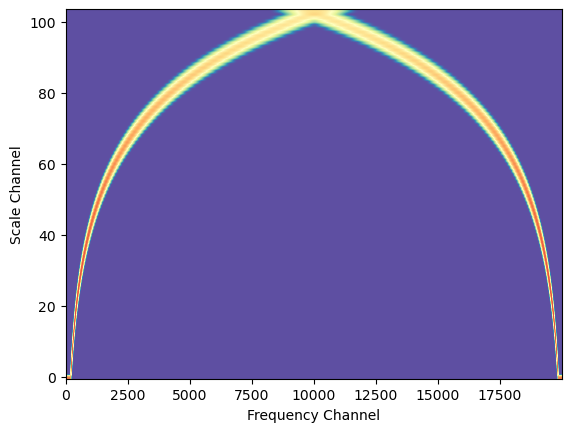

In [32]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')

8.989786692836787e-14


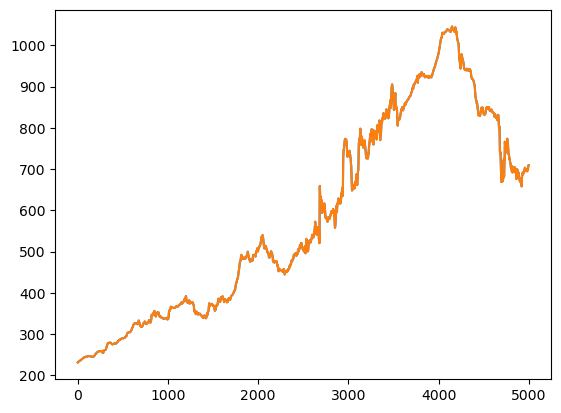

In [33]:
coeffs = transform.forward(data)
result = transform.inverse(coeffs)
print(np.mean(np.sqrt((result - data)**2)))
plt.plot(result)
plt.plot(data)

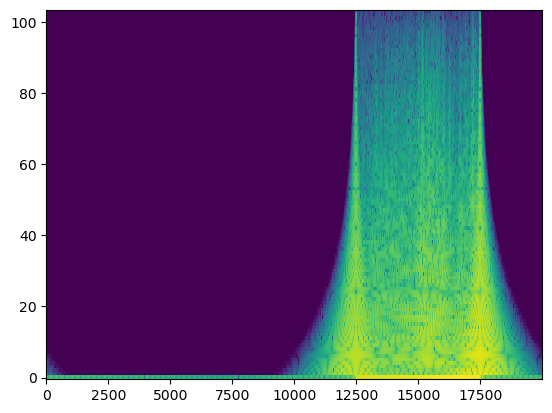

In [34]:
plt.imshow(np.log(np.abs(coeffs)+1e-5), aspect='auto', origin='lower', interpolation='none')

#### Transform


In [42]:
# Perform forward wavelet transform
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])

D = w2 - w1  # shape (J, T), complex

# 1) correlations (eqs 6–7), using conjugate inner products
C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

# 2) gain estimate K̂ per scale (eq 8)
K_hat = C2 / C1                          # shape (J,)
# (optionally force to real if you know K is real:)
K_hat = K_hat

# 3) stray‑field estimate A(s,τ) (eq 9)
A = D / (K_hat[:,None] - 1)              # shape (J, T), complex

# 4) ambient‑field estimate X(s,τ) (eq 10)
X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 

result = transform.inverse(np.copy(X))


Raw Error:  79.04269004486584
Raw Error:  282.8971635273557
Cleaned Error:  0.6119337776674528


C:\Users\Alex\AppData\Local\Temp\ipykernel_8624\4040354371.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend()


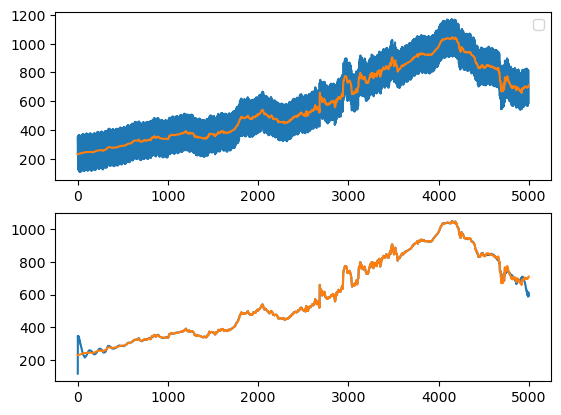

In [43]:
print("Raw Error: ", np.sqrt(((B[0,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Raw Error: ", np.sqrt(((B[1,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Cleaned Error: ", np.sqrt(((data[1000:-1000]-result[1000:-1000])**2).mean(axis=0)))

fig, ax = plt.subplots(2,1)

ax[0].legend()
ax[0].plot(B[0])
ax[0].plot(data)
ax[1].plot(result)
ax[1].plot(data)

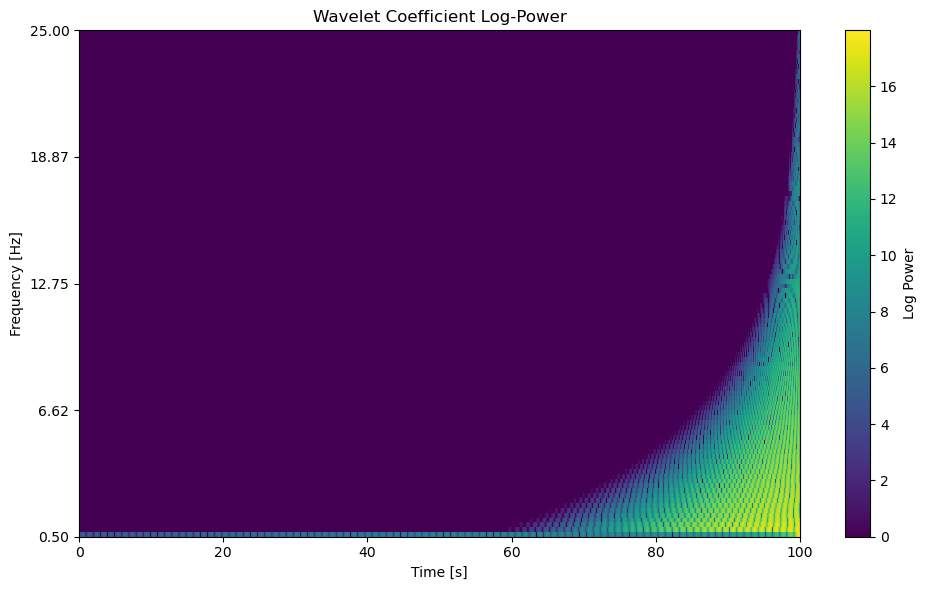

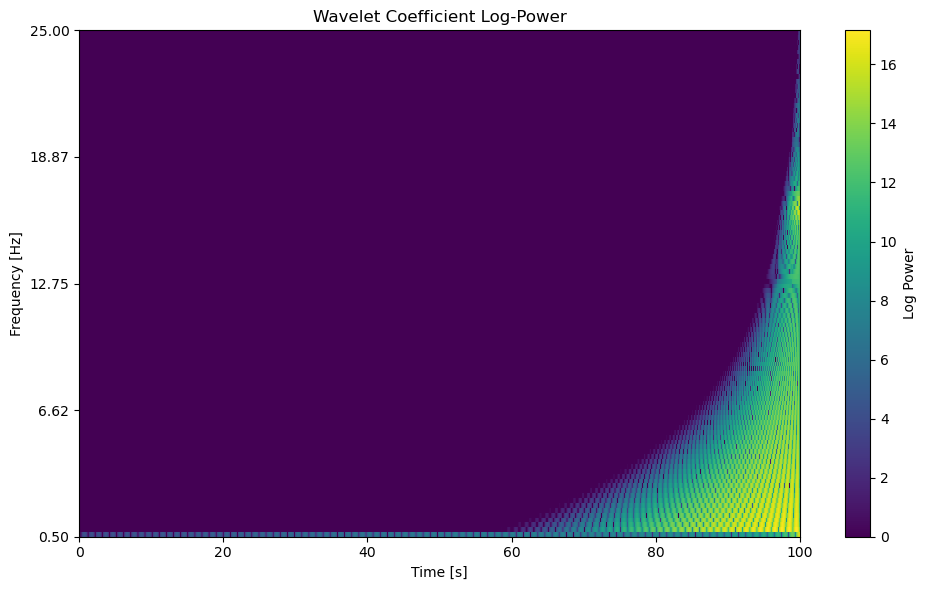

In [37]:
transform.scalogram(X, vmin=0, interpolation='none')
transform.scalogram(w2,vmin=0, interpolation='none')

#### Compare to Normal WAICUP

(199.67710912648752+0j)
11.388402150724197


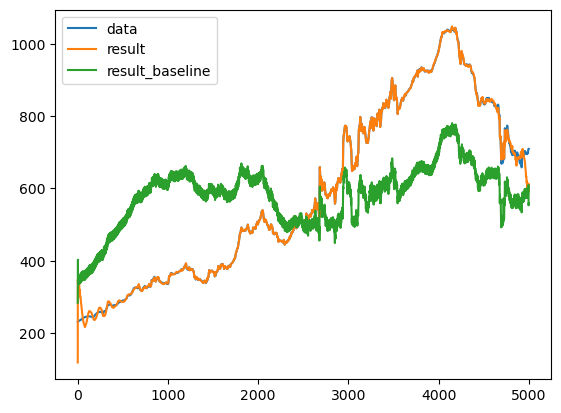

In [41]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend= False
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
print(np.sqrt(((data-result)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result')
plt.plot(result_baseline, label='result_baseline')
plt.legend()

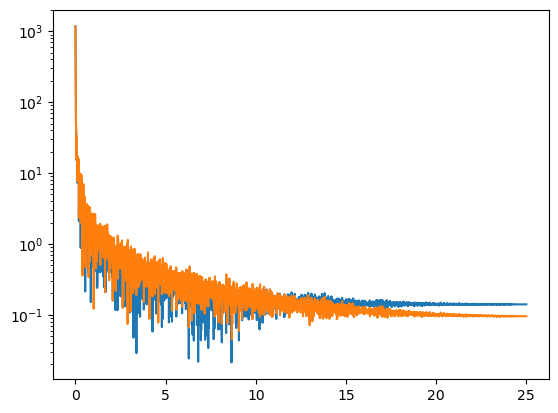

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 5000
# sample spacing
T = 1.0 / 50
x = np.linspace(0.0, N*T, N)
y = data
yf = scipy.fftpack.fft(y)
yf2 = scipy.fftpack.fft(result)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf2[:N//2]))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))


ax.set_yscale('log')
plt.show()


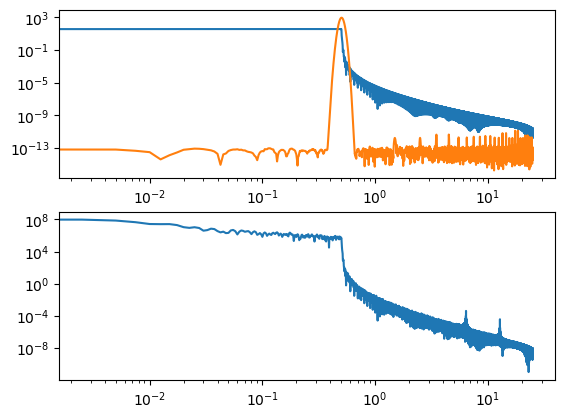

In [13]:
fig, ax = plt.subplots(2,1)
i = 0
N = w1.shape[-1]
freqs = np.fft.fftfreq(N, d=1/sample_rate)
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i][:N//2]))
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i+1][:N//2]))
ax[1].plot(freqs[:N//2], np.abs(np.fft.fft(w1, axis=1))[i][:N//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')